Steps :

1. Import data set
2. process the data into a pandas data frame
3. clean the data
4. get data includding : 
    1. Who sent in the most and least messages ( graph?)
    2. Who used the most emojis?
    5. Who asked the most questions?
    7. Night Owl - who sent the most messages late at night?


In [69]:
import re
import pandas as pd

# for plotting graphs

import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
# Importing the data

DATE_TIME = re.compile(r"([(\[]).*?([)\]])")
AUTHOR = re.compile(r"((( [a-zA-ZöäüÖÄÜ]+)+):)")
LTR = chr(8206)

def to_pd_row(s):
    match = DATE_TIME.match(s)
    if match:
        g = match.group(0)
        date = pd.to_datetime(g[1:11])
        time = g[13:-1]
        author = re.search(AUTHOR, s).group(0)[1:-1]
        message = s.split(': ')[1]
        return date, time, author, message.replace("\n", "")

def chat():
    filename = "./ChatApril2024.txt"
    try:
        with open(filename) as f:
            for l in f.readlines():
                yield to_pd_row(l.replace(LTR, ""))
        f.close()
    except Exception as e:
        print(f"Could not process {filename}, because the following error occured: {type(e).__name__}: {str(e)}")

if __name__ == "__main__":
    df = pd.DataFrame(data=list(chat()), columns=["Date", "Time", "Author", "Message"])
    df["Author"] = df["Author"].astype("category")

/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_18154/2984595679.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  date = pd.to_datetime(g[1:11])


In [71]:
filtered_df = df.loc[df['Date'] > '2024-01-01']
filtered_df = filtered_df.drop(filtered_df[filtered_df.Author == "Grandpa"].index)
#print(filtered_df.head())
print(len(filtered_df))

1483


In [72]:
# Export the DataFrame to an Excel file
# filtered_df.to_excel('chatApril.xlsx', index=False)
# print('DataFrame is written to Excel File successfully.')

Answering the Questions.

Now its time to process the data to get the analytics to answer each of the questions!

Starting with 
1. Who was the most and least active on the group chat?

/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_18154/3146677983.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = filtered_df.groupby('Author')
/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_18154/3146677983.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  my_plot = sns.barplot(data=group_sizes_df, x = 'Author', y = 'Frequency', order=group_sizes_df.sort_values('Frequency').Author, palette=palette)
/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_18154/3146677983.py:15: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.
  my_plot = 

[Text(0, 0, 'Grandpa'),
 Text(1, 0, 'Mother Teresa'),
 Text(2, 0, 'Gabriella'),
 Text(3, 0, 'Matthew'),
 Text(4, 0, 'Murat'),
 Text(5, 0, 'Aunty kim'),
 Text(6, 0, 'Uncle Bob'),
 Text(7, 0, 'Cesca'),
 Text(8, 0, 'Dad'),
 Text(9, 0, 'Georgia'),
 Text(10, 0, 'Aunty Denise')]

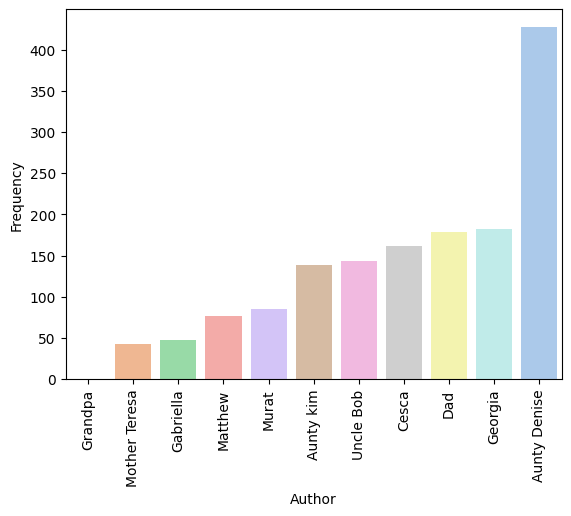

In [73]:
# As we previously edited the authors column to be a category data type, we can easily count how many messages were sent by each person using the groupby function 


grouped_df = filtered_df.groupby('Author')
group_sizes = grouped_df.size()

#category = df.category_name_column.value_counts()  
group_sizes_df = group_sizes.reset_index()
group_sizes_df.columns = ['Author', 'Frequency']
group_sizes_df = group_sizes_df.sort_values(by='Frequency')

palette = sns.color_palette("pastel")

# #create seaborn countplot
my_plot = sns.barplot(data=group_sizes_df, x = 'Author', y = 'Frequency', order=group_sizes_df.sort_values('Frequency').Author, palette=palette)
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=90)


Who used the most emojis?

In [74]:
import emoji

/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_18154/185709006.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_by_category = emojis_df.groupby('Author')['emoji_count'].sum()
/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_18154/185709006.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  emoji_count_plot = sns.barplot(data=sum_by_category, x = 'Author', y = 'Emoji Count', order=sum_by_category.sort_values('Emoji Count').Author, palette=palette)
/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_18154/185709006.py:28: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce 

[Text(0, 0, 'Grandpa'),
 Text(1, 0, 'Matthew'),
 Text(2, 0, 'Murat'),
 Text(3, 0, 'Georgia'),
 Text(4, 0, 'Cesca'),
 Text(5, 0, 'Gabriella'),
 Text(6, 0, 'Dad'),
 Text(7, 0, 'Mother Teresa'),
 Text(8, 0, 'Aunty kim'),
 Text(9, 0, 'Uncle Bob'),
 Text(10, 0, 'Aunty Denise')]

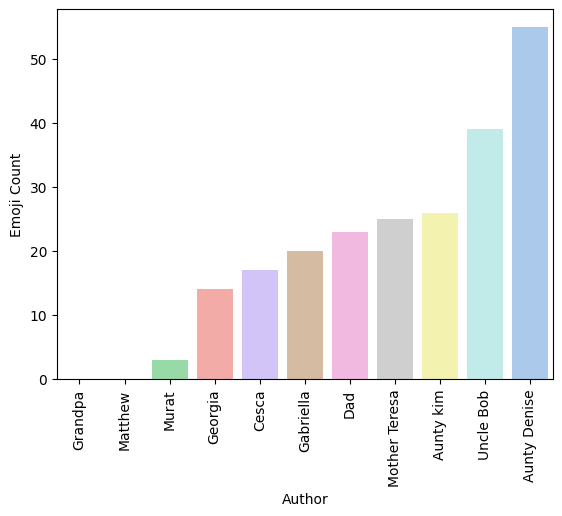

In [75]:
emojis_df = filtered_df.copy()

# Function to count the number of emojis in a string
def count_emojis(text):
    return emoji.emoji_count(text)


# Apply the function to the 'Message' column
emojis_df['emoji_count'] = emojis_df['Message'].apply(count_emojis)



sum_by_category = emojis_df.groupby('Author')['emoji_count'].sum()
sum_by_category = sum_by_category.reset_index()
sum_by_category.columns = ['Author', 'Emoji Count']
sum_by_category = sum_by_category.sort_values(by='Emoji Count')



# palette = sns.color_palette("pastel")

emoji_count_plot = sns.barplot(data=sum_by_category, x = 'Author', y = 'Emoji Count', order=sum_by_category.sort_values('Emoji Count').Author, palette=palette)
emoji_count_plot.set_xticklabels(emoji_count_plot.get_xticklabels(), rotation=90)




5. Who asked the most questions?

/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_18154/469634693.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  no_questions_df = questions_df.groupby('Author')['question'].sum()
/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_18154/469634693.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  questions_count_plot = sns.barplot(data=no_questions_df, x = 'Author', y = 'Number of Questions Asked', order=no_questions_df.sort_values('Number of Questions Asked').Author, palette=palette)
/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_18154/469634693.py:12: UserWarning: 
The palette list has fewer values (10) than needed (11) and

[Text(0, 0, 'Grandpa'),
 Text(1, 0, 'Murat'),
 Text(2, 0, 'Matthew'),
 Text(3, 0, 'Mother Teresa'),
 Text(4, 0, 'Uncle Bob'),
 Text(5, 0, 'Gabriella'),
 Text(6, 0, 'Aunty kim'),
 Text(7, 0, 'Cesca'),
 Text(8, 0, 'Aunty Denise'),
 Text(9, 0, 'Dad'),
 Text(10, 0, 'Georgia')]

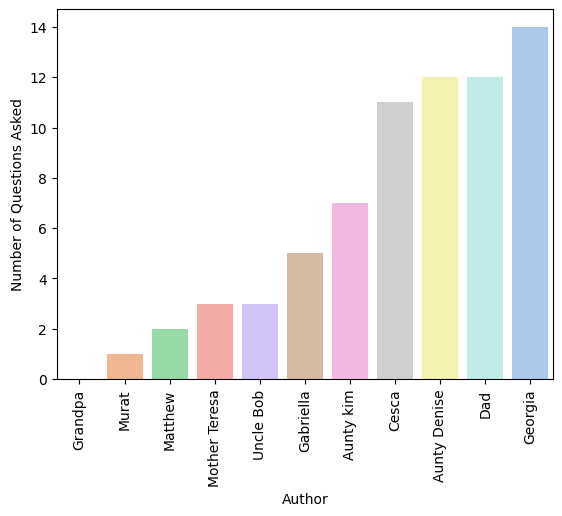

In [79]:
questions_df = filtered_df.copy()

questions_df['question'] = questions_df['Message'].str.contains("\?")

no_questions_df = questions_df.groupby('Author')['question'].sum()
no_questions_df = no_questions_df.reset_index()
no_questions_df.columns = ['Author', 'Number of Questions Asked']
no_questions_df = no_questions_df.sort_values(by='Number of Questions Asked')

palette = sns.color_palette("pastel")

questions_count_plot = sns.barplot(data=no_questions_df, x = 'Author', y = 'Number of Questions Asked', order=no_questions_df.sort_values('Number of Questions Asked').Author, palette=palette)
questions_count_plot.set_xticklabels(questions_count_plot.get_xticklabels(), rotation=90)

Who wrote the most messages at night?

/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_18154/1624022070.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  times_df['Time'] = pd.to_datetime(times_df['Time'])
/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_18154/1624022070.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  no_late_texts_df = late_times_df.groupby('Author')['Message'].count()
/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_18154/1624022070.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  late_texts_count_plot

[Text(0, 0, 'Grandpa'),
 Text(1, 0, 'Gabriella'),
 Text(2, 0, 'Mother Teresa'),
 Text(3, 0, 'Aunty kim'),
 Text(4, 0, 'Georgia'),
 Text(5, 0, 'Cesca'),
 Text(6, 0, 'Dad'),
 Text(7, 0, 'Matthew'),
 Text(8, 0, 'Uncle Bob'),
 Text(9, 0, 'Aunty Denise'),
 Text(10, 0, 'Murat')]

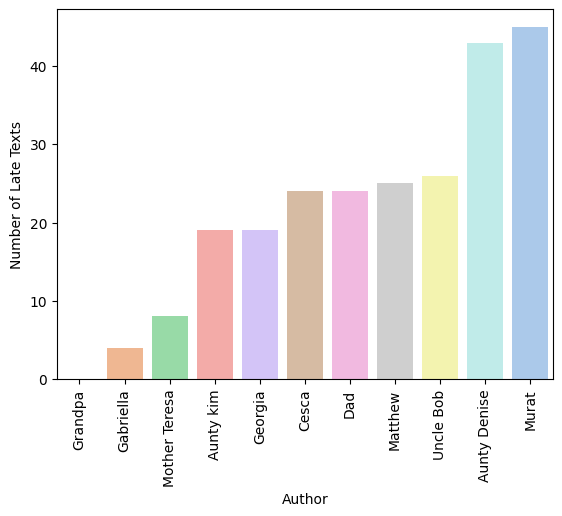

In [80]:
times_df = filtered_df.copy()

#convert to a date time
times_df['Time'] = pd.to_datetime(times_df['Time'])



#filter the data frame
# mask = (times_df['Time'].dt.time >= pd.Timestamp('20:00:00').time()) | (times_df['Time'].dt.time <= pd.Timestamp('4:00:00').time())
# late_times_df = df.loc[mask]



start_time = pd.to_datetime('20:00:00').time()
end_time = pd.to_datetime('4:00:00').time()

late_times_df = times_df[(times_df['Time'].dt.time >= start_time) | (times_df['Time'].dt.time <= end_time)]


#plot
no_late_texts_df = late_times_df.groupby('Author')['Message'].count()
no_late_texts_df = no_late_texts_df.reset_index()
no_late_texts_df.columns = ['Author', 'Number of Late Texts']
no_late_texts_df = no_late_texts_df.sort_values(by='Number of Late Texts')
no_late_texts_df.head()

palette = sns.color_palette("pastel")

late_texts_count_plot = sns.barplot(data=no_late_texts_df, x = 'Author', y = 'Number of Late Texts', order=no_late_texts_df.sort_values('Number of Late Texts').Author, palette=palette)
late_texts_count_plot.set_xticklabels(late_texts_count_plot.get_xticklabels(), rotation=90)



Who sent the most images and videos?